In [2]:
!pip install catboost xgboost

  Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-5.22.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached tenacity-8.3.0-py3-none-any.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 17.5 MB/s eta 0:00:0000:0100:01
Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl (1.9 MB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Using cached plotly-5.22.0-py3-none-any.whl (16.4 MB)
Using cached tenacity-8.3.0-py3-none-any.whl (25 kB)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [4]:
data = pd.read_csv("./data/stud.csv")
data.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
x = data.drop(columns='math_score', axis=1)
x.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [6]:
print("Categories in the 'gender' variable: ", end=" ")
print(data['gender'].unique())

print("Categories in the 'race_ethnicity' variable: ", end=" ")
print(data['race_ethnicity'].unique())

print("Categories in the 'parental_level_of_education' variable: ", end=" ")
print(data['parental_level_of_education'].unique())

print("Categories in the 'lunch' variable: ", end=" ")
print(data['lunch'].unique())

print("Categories in the 'test_preparation_course' variable: ", end=" ")
print(data['test_preparation_course'].unique())

Categories in the 'gender' variable:  ['female' 'male']
Categories in the 'race_ethnicity' variable:  ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in the 'parental_level_of_education' variable:  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in the 'lunch' variable:  ['standard' 'free/reduced']
Categories in the 'test_preparation_course' variable:  ['none' 'completed']


In [7]:
y = data['math_score']
y.head(10)

0    72
1    69
2    90
3    47
4    76
5    71
6    88
7    40
8    64
9    38
Name: math_score, dtype: int64

In [8]:
# Create Column Transformer with 3 types of transformers
numerical_features = x.select_dtypes(exclude="object").columns
categorical_features = x.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_features),
        ("StandardScaler", numeric_transformer, numerical_features),        
    ]
)

In [9]:
x = preprocessor.fit_transform(x)
x.shape

(1000, 19)

In [12]:
# split dataset into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
(x_train.shape, x_test.shape)

((800, 19), (200, 19))

In [13]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('=' * 35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3242
- Mean Absolute Error: 4.2684
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.4011
- Mean Absolute Error: 4.2176
- R2 Score: 0.8801


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7079
- Mean Absolute Error: 4.5168
- R2 Score: 0.8555
-----------------------

In [15]:
pd.DataFrame(list(zip(model_list, r2_list)), 
             columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880118
5,Random Forest Regressor,0.855831
7,CatBoosting Regressor,0.851632
8,AdaBoost Regressor,0.850810
6,XGBRegressor,0.827797
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.730869


In [16]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
score = r2_score(y_test, y_pred) * 100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.01


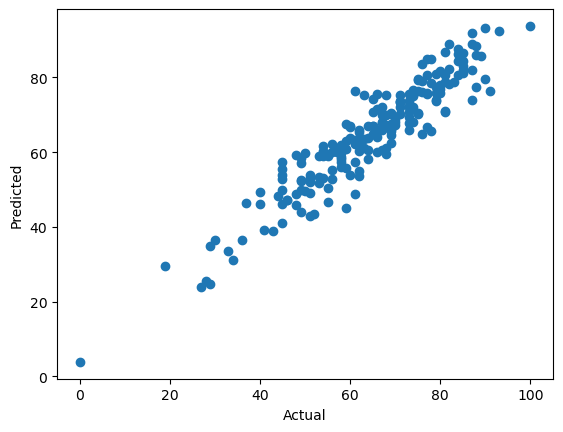

In [17]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

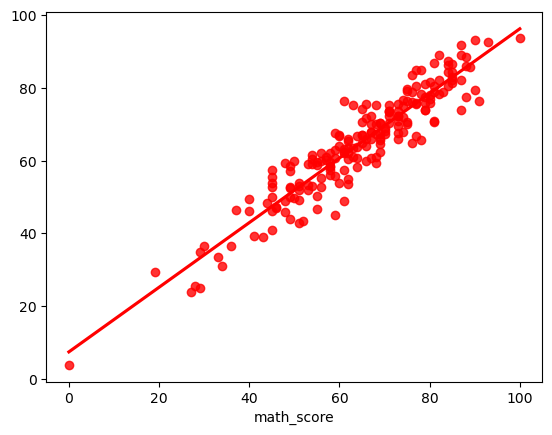

In [18]:
sns.regplot(x=y_test, y=y_pred, ci=None, color ='red');

In [19]:
pred_data = pd.DataFrame({'Actual Value':y_test, 'Predicted Value':y_pred, 'Difference':y_test - y_pred})
pred_data

,Actual Value,Predicted Value,Difference
521,91,76.453125,14.546875
737,53,58.968750,-5.968750
740,80,76.890625,3.109375
660,74,76.703125,-2.703125
411,84,87.484375,-3.484375
...,...,...,...
408,52,43.515625,8.484375
332,62,62.031250,-0.031250
208,74,67.968750,6.031250
613,65,67.109375,-2.109375
